In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

csv_path = 'datasets/students_simple.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Файл '{csv_path}' не найден!")

df = pd.read_csv(csv_path)
n = len(df)

N = 17
x_col = N % 5
y_col = (N**2) % 5 + 5

if x_col >= df.shape[1] or y_col >= df.shape[1]:
    raise IndexError(f"В датасете всего {df.shape[1]} столбцов, а ты пытаешься взять {x_col} и {y_col}")

x = df.iloc[:, x_col].to_numpy()
y = df.iloc[:, y_col].to_numpy()

print(f"x → столбец #{x_col} ({df.columns[x_col]}), y → столбец #{y_col} ({df.columns[y_col]})")
print("Первые 5 значений x:", x[:5])
print("Первые 5 значений y:", y[:5])



x → столбец #2 (income), y → столбец #9 (test_time)
Первые 5 значений x: [430 640 610 330 420]
Первые 5 значений y: [ 8.5  6.2  6.8 12.   7.5]


Корреяции

In [47]:
mx, my = np.mean(x), np.mean(y)
sx = np.sign(x - mx)
sy = np.sign(y - my)
valid = (sx != 0) & (sy != 0)
if np.sum(valid) == 0:
    K_fechner = np.nan
else:
    sign_matches = np.sum(sx[valid] == sy[valid])
    sign_diff = np.sum(sx[valid] != sy[valid])
    K_fechner = (sign_matches - sign_diff) / np.sum(valid)
print("x =", x, type(x), "shape =", np.shape(x))
print("y =", y, type(y), "shape =", np.shape(y))

pearson_r, pearson_p = stats.pearsonr(x, y)
z = np.arctanh(pearson_r)
se = 1 / np.sqrt(n - 3)
alpha = 0.05
z_crit = stats.norm.ppf(1 - alpha/2)
ci_low = np.tanh(z - z_crit*se)
ci_high = np.tanh(z + z_crit*se)

spearman_r, spearman_p = stats.spearmanr(x, y)
kendall_r, kendall_p = stats.kendalltau(x, y)

print("Фехнера K =", K_fechner)
print("Пирсона r =", pearson_r)
print(f"Довер интервал = [{ci_low}, {ci_high}]")
print("Спирмена rho =", spearman_r)
print("Кенделла tauт =", kendall_r)


x = [430 640 610 330 420 290 480 610 840 330 560 450 350 310 380 340 660 450
 540 750] <class 'numpy.ndarray'> shape = (20,)
y = [ 8.5  6.2  6.8 12.   7.5 10.   7.2  4.2  3.5  9.5  7.8  8.   6.   4.8
  8.6 10.   4.5 12.5 10.5  6.5] <class 'numpy.ndarray'> shape = (20,)
Фехнера K = -0.4
Пирсона r = -0.5698939517430253
Довер интервал = [-0.8085153217834531, -0.170328232438795]
Спирмена rho = -0.5391567793643103
Кенделла tauт = -0.43617638325413816


Проверка направления зависимости 
Для Фехнера - обратная уверенная зависимость(только знак)
Пирсона - линейная умеренная отриц (с учетом самого отклонения)
Спирмена - монотонная умеренная (что-то с рангами вместо значенйи)

Гистограммы для обоих столбцов + график рассяения

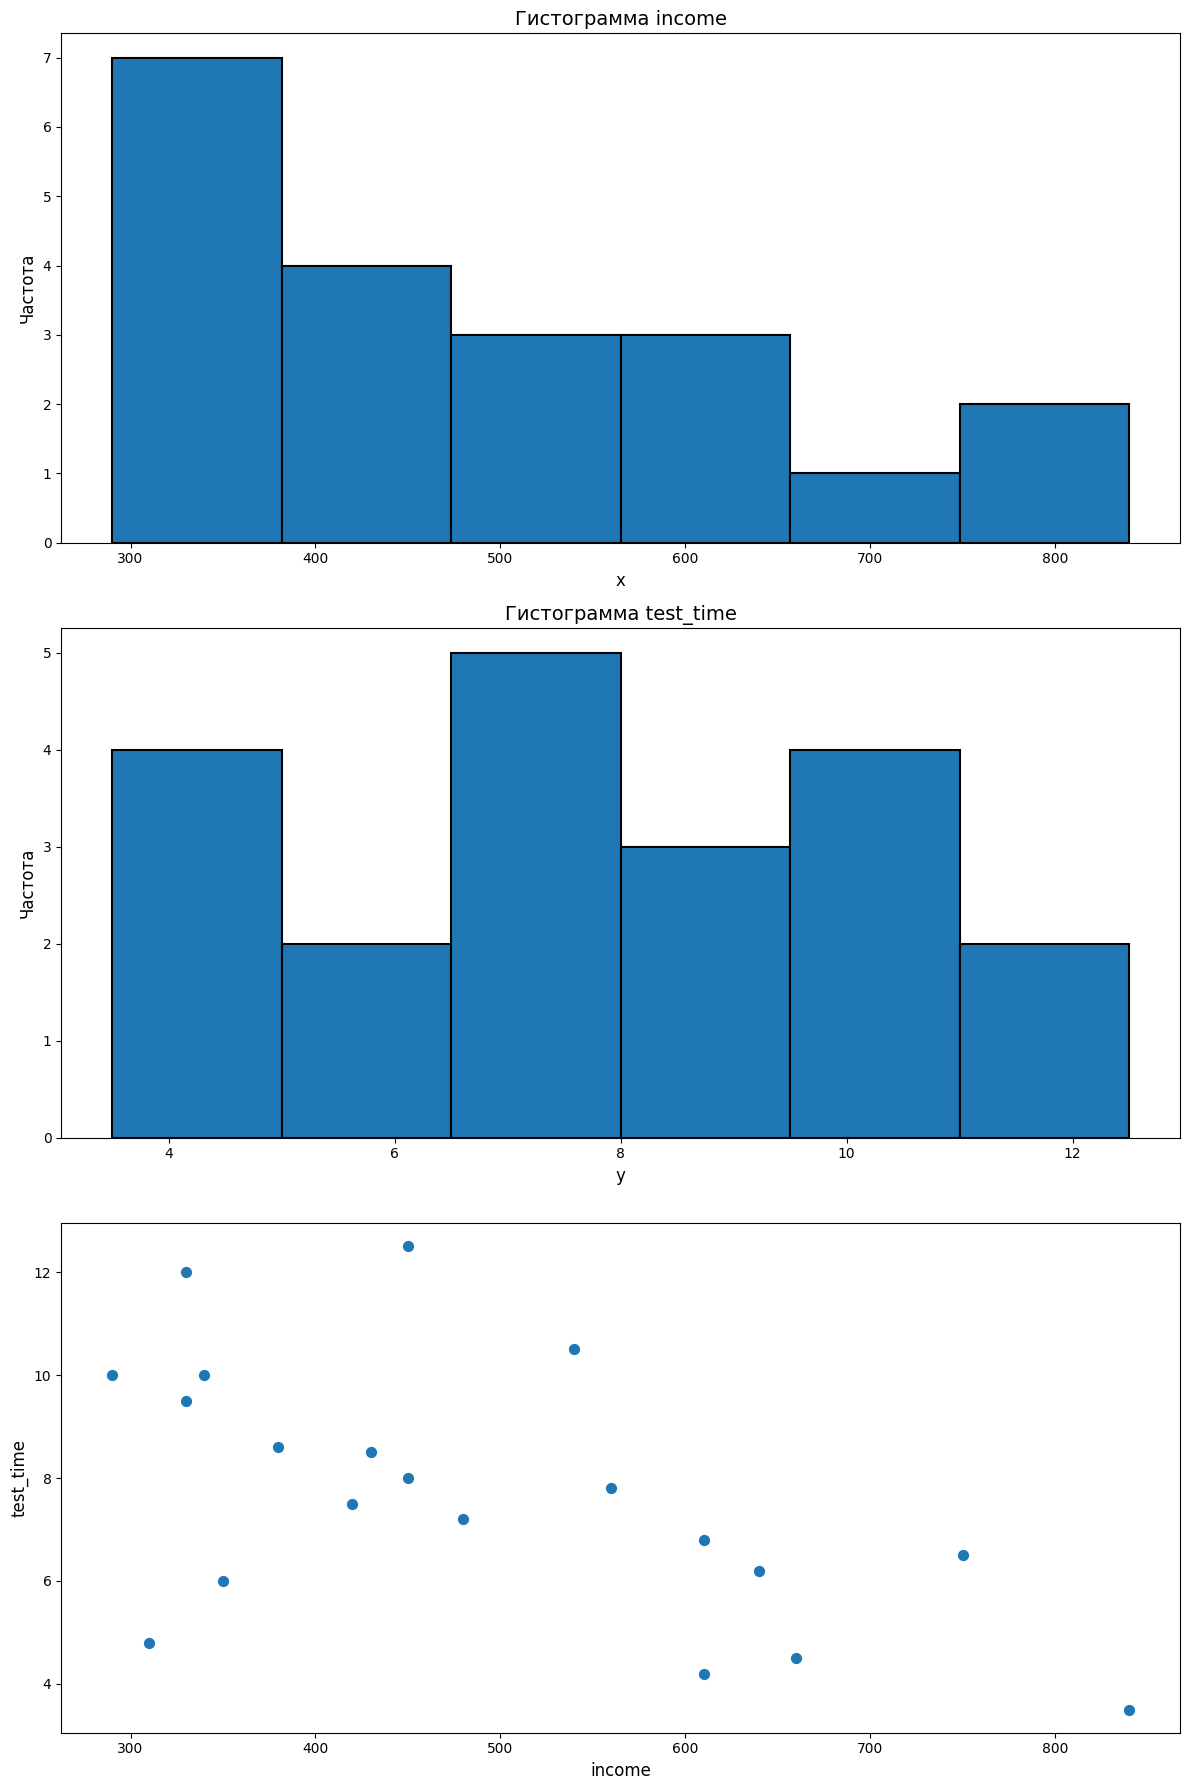

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,18))

axes[0].hist(x, bins='auto', edgecolor='black', linewidth=1.5)
axes[0].set_title(f"Гистограмма {df.columns[x_col]}", fontsize=14)
axes[0].set_xlabel("x", fontsize=12)
axes[0].set_ylabel("Частота", fontsize=12)

axes[1].hist(y, bins='auto', edgecolor='black', linewidth=1.5)
axes[1].set_title(f"Гистограмма {df.columns[y_col]}", fontsize=14)
axes[1].set_xlabel("y", fontsize=12)
axes[1].set_ylabel("Частота", fontsize=12)

axes[2].scatter(x, y, s=50)
axes[2].set_xlabel(f"{df.columns[x_col]}", fontsize=12)
axes[2].set_ylabel(f"{df.columns[y_col]}", fontsize=12)

plt.tight_layout()
plt.show()


Уравнения регрессии по видам + проверка по Фишеру

linear: R2 = 0.3247791162332816
quadratic: R2 = 0.3541756839806708
hyperbolic: R2 = 0.2427717240643339
exponential: R2 = 0.28800817214395036


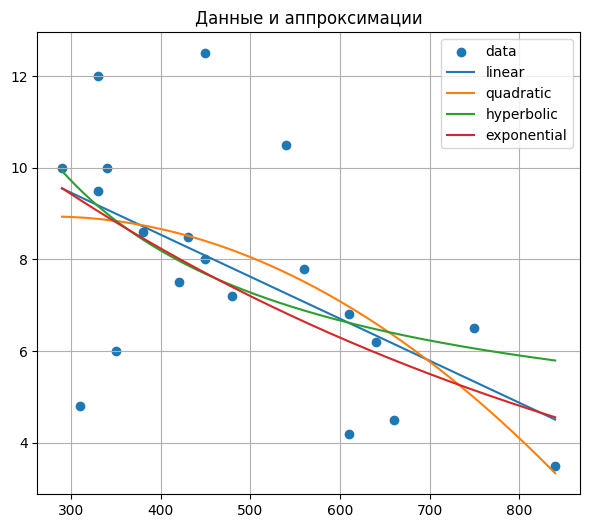

Best model: quadratic R2= 0.3541756839806708 F= 4.661474086933573 Fcrit_0.05= 3.5915305684750827
Worst model: hyperbolic R2= 0.2427717240643339 F= 5.770903137179303 Fcrit_0.05= 4.413873419170567


array([430, 640, 610, 330, 420, 290, 480, 610, 840, 330, 560, 450, 350,
       310, 380, 340, 660, 450, 540, 750])

In [ ]:
models = {}
def add_model(name, y_pred, params_k, coef=None):
    mask = ~np.isnan(y_pred)
    R2 = r2_score(y[mask], y_pred[mask]) if np.sum(mask)>1 else np.nan
    models[name] = {"pred": y_pred, "R2": R2, "k": params_k, "coef": coef}

X_lin = x.reshape(-1,1)
lr = LinearRegression().fit(X_lin, y)
pred_lin = lr.predict(X_lin)
add_model("linear", pred_lin, 2, coef=(lr.coef_[0], lr.intercept_))

X_quad = np.column_stack([x**2, x, np.ones_like(x)])
coef_quad, *_ = np.linalg.lstsq(X_quad, y, rcond=None)
pred_quad = X_quad.dot(coef_quad)
add_model("quadratic", pred_quad, 3, coef=tuple(coef_quad))

pred_hyp = np.full_like(y, np.nan, dtype=float)
mask_nz = x != 0
if np.any(mask_nz):
    A = np.column_stack([1/x[mask_nz], np.ones(np.sum(mask_nz))])
    coef_hyp, *_ = np.linalg.lstsq(A, y[mask_nz], rcond=None)
    pred_hyp[mask_nz] = A.dot(coef_hyp)
add_model("hyperbolic", pred_hyp, 2, coef=(tuple(coef_hyp) if np.any(mask_nz) else None))

if np.all(y>0):
    lny = np.log(y)
    b, a = np.polyfit(x, lny, 1)
    w1 = np.exp(b)
    w0 = np.exp(a)
    pred_exp = w0 * (w1 ** x)
else:
    pred_exp = np.full_like(y, np.nan, dtype=float)
add_model("exponential", pred_exp, 2, coef=(w0, w1) if np.all(y>0) else None)

for name, info in models.items():
    print(f"{name}: R2 = {info['R2']}")

plt.figure(figsize=(7,6))
plt.scatter(x, y, label='data')
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, lr.predict(xs.reshape(-1,1)), label='linear')
plt.plot(xs, np.column_stack([xs**2, xs, np.ones_like(xs)]).dot(coef_quad), label='quadratic')
if np.any(mask_nz):
    plt.plot(xs[xs!=0], coef_hyp[0]/xs[xs!=0] + coef_hyp[1], label='hyperbolic')
if np.all(y>0):
    plt.plot(xs, w0 * (w1 ** xs), label='exponential')
plt.legend(); plt.title("Данные и аппроксимации"); plt.grid(True); plt.show()

valid = {k:v for k,v in models.items() if not np.isnan(v['R2'])}
sorted_models = sorted(valid.items(), key=lambda kv: kv[1]['R2'])
worst_name, worst_m = sorted_models[0]
best_name, best_m = sorted_models[-1]

def fisher_F(R2, k, n):
    return (R2/(1-R2)) * ((n-k)/(k-1))

best_F = fisher_F(best_m['R2'], best_m['k'], n)
worst_F = fisher_F(worst_m['R2'], worst_m['k'], n)
Fcrit_best = stats.f.ppf(0.95, best_m['k']-1, n-best_m['k'])
Fcrit_worst = stats.f.ppf(0.95, worst_m['k']-1, n-worst_m['k'])
print("Best model:", best_name, "R2=", best_m['R2'], "F=", best_F, "Fcrit_0.05=", Fcrit_best)
print("Worst model:", worst_name, "R2=", worst_m['R2'], "F=", worst_F, "Fcrit_0.05=", Fcrit_worst)
x

Оба значимы по Фишеру, так как F > F_crit
R^2 коэф детерминации ( 1 - объясняет все, 0 - ничего, 0-1 - часть, <0 - плохо)